In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# 1. Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
columns = ['label'] + [f'feature_{i}' for i in range(1, 17)]
df = pd.read_csv(url, header=None, names=columns)

In [3]:
df.head()

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [4]:
df.shape

(20000, 17)

In [5]:
# 2. Encode labels (A–Z -> 0–25)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [6]:
df.head()

,label,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16
0,19,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,8,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,3,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,13,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,6,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [7]:
# 3. Train/Test split
X = df.drop('label', axis=1).values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 4. PyTorch Dataset
class OCRDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = OCRDataset(X_train, y_train)
test_dataset = OCRDataset(X_test, y_test)


In [9]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
# 5. Define DNN model
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),             #MML
            nn.Linear(64, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 26)  # 26 classes for A–Z
        )

    def forward(self, x):
        return self.net(x)

model = DNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# 6. Training
epochs = 100
for epoch in range(epochs):  # 100 epochs
    model.train()
    for data, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.4633
Epoch 20, Loss: 0.4894
Epoch 30, Loss: 0.2627
Epoch 40, Loss: 0.1517
Epoch 50, Loss: 0.2130
Epoch 60, Loss: 0.0679
Epoch 70, Loss: 0.1667
Epoch 80, Loss: 0.1581
Epoch 90, Loss: 0.1200
Epoch 100, Loss: 0.2111


In [12]:
all_preds = []
all_labels = []
#MML
with torch.no_grad():
    for data, targets in test_loader:
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

In [13]:
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Classification Report:

              precision    recall  f1-score   support

           A       0.98      0.98      0.98       149
           B       0.90      0.90      0.90       153
           C       0.92      0.91      0.91       137
           D       0.94      0.94      0.94       156
           E       0.87      0.94      0.90       141
           F       0.92      0.91      0.91       140
           G       0.87      0.93      0.90       160
           H       0.87      0.81      0.84       144
           I       0.94      0.94      0.94       146
           J       0.94      0.97      0.96       149
           K       0.88      0.89      0.89       130
           L       0.94      0.97      0.96       155
           M       0.98      0.96      0.97       168
           N       0.96      0.93      0.95       151
           O       0.91      0.94      0.93       145
           P       0.95      0.92      0.93       173
           Q       0.95      0.96      0.96       166
  

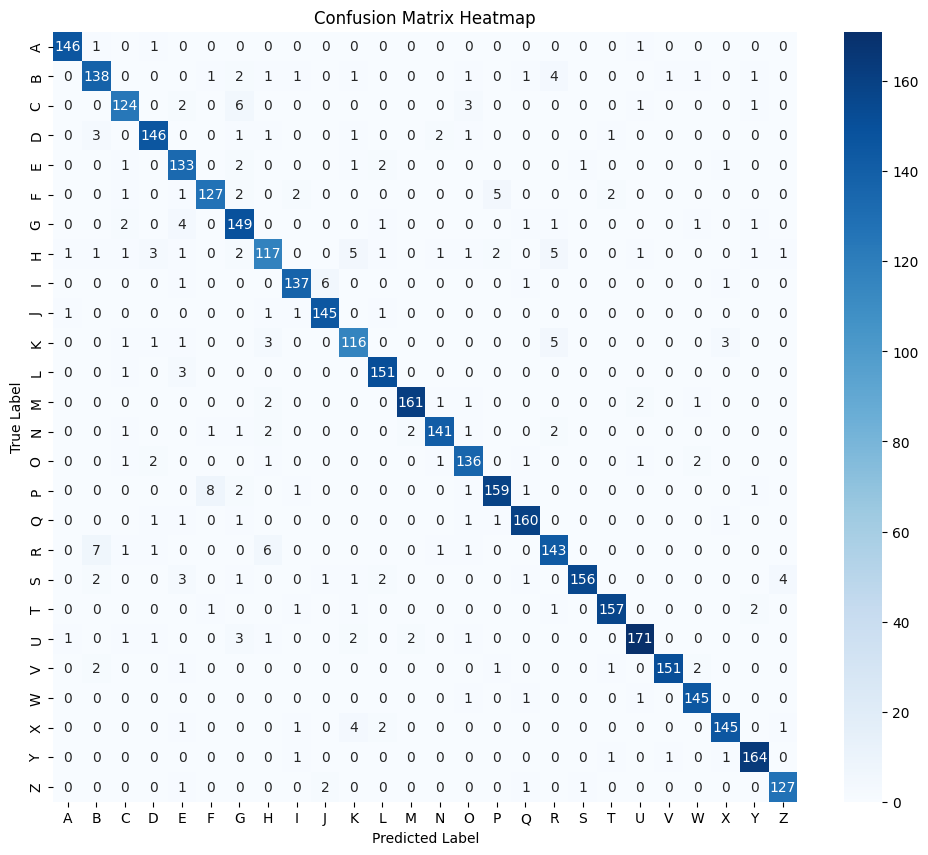

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()
